# The Chicken or the Beef? Why Everyone Loves Neural Networks

*by Ra Inta*

*MIT licence, 2019*

## Overview
You're probably here because you've heard how awesome Artificial Neural Networks (ANNs) or Deep Learning algorithms are, and would like to know a few more details. Welcome! Make yourself at home.

We'll take you on a brief tour of the conceptual foundations behind ANNs, through the lens of having to make a meal choice whilst stuck on a long plane flight. We'll see how to encode this problem using Python's Keras and TensorFlow libraries, before extending the model to more complex cases, by constructing ANNs with various architectures. This will lead the way -- at least provide a sketch of the intricate map -- towards Deep Learning.

## Libraries

In [1]:
import os
import pathlib
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
## Enable inline plotting for graphics
%matplotlib inline
## Output more than the last command in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

These are the versions of the libraries I will be using for this notebook:

In [4]:
print(sys.version)
print("Pandas version: {0}".format(pd.__version__))
print("Matplotlib version: {0}".format(matplotlib.__version__))
print("Numpy version: {0}".format(np.__version__))
print("Tensorflow version: {0}".format(tf.__version__))

3.6.7 | packaged by conda-forge | (default, Feb 26 2019, 03:50:56) 
[GCC 7.3.0]
Pandas version: 0.24.1
Matplotlib version: 3.0.3
Numpy version: 1.15.4
Tensorflow version: 1.10.0


## The most basic artificial neuron: the Perceptron

Let's say you have an important decision to make. You are hungry and wish to be sated. However, you are on an airplane, so your options are 'chicken' or 'beef'. Your target variable is 'satisfaction,' which will not be achieved if you choose neither, or both, options. You must make this decision while you have the flight attendant's attention. Finally, the attendant is new and very busy, and may not recall your first choice, so you will have to be explicit about what you _do not_ wish, as well as what you do (or perhaps they ran out of one option and another attendant has to provide this option later, without information on the first meal option).

This contrived scenario is simple by design. Yet how would we go about modeling this decision?

We could approach this as a linear regression problem: $f(x) = w_1x_1 + w_2x_2 + b$, where the $w_i$ are the weights of the inputs $x_i$, and minimize the least squares cost function, $J(x) = \sum_{r} (f'(x) - f(x))^2$, where the $r$ run over all the input values.

However, consider an intrinsic problem here. The final decision depends wholly on the interaction between the two input variables, 'chicken' (say, $x_1$) or 'beef' ($x_2$):

![Decision plane for meals... on a plane](images/chicken_or_beef_decision_plane.png)

If $x_1$ is maximal, we wish the value of $x_2$ to be minimal, and vice-versa. But we can't just change the coefficients from a regression at will!

In other words, there is no single line that separates the Chicken-Beef ($x_1-x_2$) plane to define a distinct _decision boundary_ between the two classes, 'sated' and 'not sated'. However, we may do this with _two_ lines (and logical comparisons):

![Division of decision plane using two linear regions](images/chicken_or_beef_twoLines2.png)

The lower (green) line marks a boundary between the (0, 0) point and the other three, containing all but the origin point. The upper (blue) line defines a region that contains only the (1, 1) point.

In other words, the regions defined by:

$x_2 \geq -x_1 + 0.5$

$x_2 \geq -x_1 + 1.2$

each return 1 if the condition is met (note that we had a _lot_ of flexibility here; we just had to choose two lines that separated the two classes. I just chose those with slopes of -1 each, for simplicity). This may be re-cast:

$x_1 + x_2 \geq 0.5 \rightarrow H(x_1 + x_2 - 0.5)$

$x_1 + x_2 \geq 1.2 \rightarrow H(x_1 + x_2 - 1.2)$

The simplest function to return a 1 or 0 depending on a fixed criterion, is the Heaviside step-function, $H(x)$, with the following properties:
$H(x) = \{ ^{1\textrm{ for }x > 0} _{0\textrm{ for x } \leq 0}$

A schematic allowing these two lines to interact with each other, for this comparison may look like:

![Schematic of algorithm determining membership of classification regions ('sated' and 'not sated')](images/Simple_MLP_figure.png)

Where the last calculation is a simple logical comparison (`and`) of the regions.

This, which is really the construction of the XOR function, is the essential idea behind the most fundamental neural net: the perceptron. 

We have just seen that, while a trusty linear regression failed to model our meal satisfaction function, a collection of simple units that can easily interact and compare with each other, performed the task quite nicely.

## Artificial Neural Networks (ANNs)

Artificial Neural Networks (ANNs; often further abbreviated to NNs) are inspired directly from our understanding of brain neurophysiology. An individual _neuron_ is the basic cell unit of our complex central nervous system. Each neuron takes inputs, in the form of electrical signals, and performs a number of simple transforms on these inputs, resulting in a simple output. These outputs are in turn fed as inputs to other neurons.

Artificial neurons are simplified analogs of these biological units, taking in a limited number of signals, performing simple operations on them, before emitting a limited number of output signals. The astounding computational capabilities of this class of algorithm arise from the networks built up using these simple units.

### Anatomy of a Neural Network 

An ANN is composed of _neurons_ (_nodes_) and _layers_. Each node performs the atomic operations of the network, defined by _activation functions_. Groups of nodes may form a layer, a distinct structure representing a stage of the network. Each layer acts like a filter, or function. At least two layers are defined: the _input layer_ and the _output layer_. In addition, there may be one or more layer that is neither an input nor an output; these are referred to as _hidden layers_:



![Achitecture of a typical Artificial Neural Network (ANN). The number of layers determine the _depth_ of the model; the number of neurons in each layer determine the _width_ of the model.](images/ANN_architecture_intro.png)

The purpose of ANNs is to approximate any arbitrary function, say, $f'(x)$. Each layer can be thought of as a successive function $f_i()$ acting on the previous layers. The particular composition of layers and nodes of a neural network is known as the _net architecture_.

In this framework, for the chicken-beef calculation we performed above, each linear comparison was performed within a node (neuron), after being fed inputs $x_1$ and $x_2$. The outputs were fed into the final, output, node. This architecture is a Multi-Layer Perceptron (MLP). It is a particular type of _feed-forward network_, because there are no layers that make use of feedback.

The activation function we chose (fairly organically!) was the Heaviside step function, $H(x)$.

### Activation functions

The purpose of an activation function is to polarize the network (_i.e._ provide directionality), as well as condition the signals propagated throughout (very often regulated to have a limited output range). The most common activation functions are:

 *  **Perceptron** (Heaviside): $\sigma(z) = \{ ^{1\textrm{ for }z > 0} _{0\textrm{ for z } \leq 0}$

 *  **Sigmoid** (logistic): $\sigma(z) = \frac{1}{1 + \exp(-z)}$
 
 * **ReLU** (Rectified Linear Unit): $\sigma(z) = \max{(0, z)}$

 *  **Softmax**: $\sigma(z)_j = \frac{\exp{(z_j)}}{\sum_{k}^{K} \exp{(z_k)}}$
 
Their response functions look like the following:

![Response functions of three of the most popular activation functions for neurons in ANNs.](images/activation_function_comparison.png)

The sigmoid (or logistic) activation function is a smoothed version of the step function, so has nicer analytic properties than the step function. However, it can be somewhat computationally expensive for large numbers of nodes and layers. The ReLU (Rectified Linear Unit) is a simpler function. Although, being piece-wise linear, it is still technically non-linear, it provides network polarity while retaining many properties of linearity which make these nice for approximating functions. ReLU-based neurons are much 'faster' to train because of their computational simplicity.

The softmax activation function is an ensemble function, often used for an aggregation step. It also has nice analytic properties, regulating the output based on the ensemble mean. This often favors a 'winner-takes-all' condition.

So much for the theory. How do we code these things?

### Introduction to Keras and Tensorflow


**Tensorflow**

TensorFlow was developed by the Google Brain team, released to the Apache foundation in late 2015. It is a symbolic, high-performance, math library with specialized and generalized math objects, particularly _tensors_, a generalization of vector arithmetic and calculus (hence the name). The mental model for TensorFlow computations is a computational graph, defined by tensors. It is designed to be seamlessly applied to a range of hardware types (including GPGPUs and a specialized ASIC, the TPU---_Tensor Processing Unit_).  

**Tensorflow documentation:** https://www.tensorflow.org/

---
**Keras**

Keras is a high-level API to the neural network libraries CNTK, Theano and TensorFlow. Its high level of abstraction allows rapid prototyping of neural networks, with both convolution and recurrent network architectures. Its guiding principles are user-friendliness, modularity and to be easily extendible. Because it's written in Python, configuration and extension of functionality are relatively seamless within the Python eco-system. 

Keras is Greek for 'horn,' a reference to the vision-inducing spirits in the _Odyssey_.

**Keras documentation:** https://keras.io/

### Tensors and TensorFlow

The fundamental unit of computation within TensorFlow is the _tensor_. Tensors are generalizations of vector arithmetic and calculus, allowing linear operations on higher rank objects. These are used to partially define a computation, in the form of a data-flow graph, that will, when executed, produce an output value. TensorFlow constructs a graph based on tensor objects (`tf.Tensor`). This graph is then executed within a TensorFlow session (`tf.Session()`) instance.

We can simply generate a tensor object using `tf.Variable`:

In [22]:
odd_nums = tf.Variable([1, 3, 5, 7, 9, 11])  # Rank 1 tensor is a vector

It has the usual `.dtype` and `.shape` attributes: 

In [23]:
odd_nums.dtype
odd_nums.shape

tf.int32_ref

TensorShape([Dimension(6)])

In [24]:
weird_hypercube = tf.Variable([ [ [43], [121.234] ], [ [987], [2134] ] ], dtype=tf.float64)

However, as mentioned, tensors in TensorFlow are _partially_ computed graph objects:

In [25]:
rank1 = tf.rank(odd_nums)
rank1

<tf.Tensor 'Rank_2:0' shape=() dtype=int32>

In [26]:
rank2 = tf.rank(weird_hypercube)
rank2

<tf.Tensor 'Rank_3:0' shape=() dtype=int32>

In [27]:
weird_hypercube

<tf.Variable 'Variable_3:0' shape=(2, 2, 1) dtype=float64_ref>

Operations are not run until we have specified that our computation graph is complete. Note that the `tf.rank()` operations did not return an actual rank value. To execute operations on the tensors we just produced, we require a `tf.Session()` connection:

In [28]:
with tf.Session() as sess:
    sess.run(rank1)
    sess.run(rank2)

1

3

Defining the details of your computation this way, and generating the necessary graphs and sessions, requires quite some thought and a lot of boiler-plate code (of which is not particularly Pythonic!). 

There are so many commonly used operations and architectures, that a higher level API would be very useful! This is where Keras comes in.

## Using Keras and Tensorflow to Solve the Chicken-or-Beef Problem

As solving programming puzzles go, this is like smashing a walnut with a hydraulic press:


![Solving the chicken-or-beef problem with an ANN is like smashing a walnut with a hydraulic press -- or, in this case, a Bonsack machine. Original machine image in public domain; U.S. pat. #238,640](images/Walnut_press_labelled_smaller2.jpg)

![Much smaller text in description to test image](images/good-good-let-the-power-of-pandas-flow-through-you.jpg)

In fact, you'll see below that this problem is almost _too_ simple for our ANN coding framework (this occurs surprisingly often 'in the wild' at the moment too!). You will, however, hopefully see that setting up very sophisticated network architectures is made very easy using Keras. However, we’re already attached to this airplane meal puzzle, so we’ll see it through to its nutritious end.

We wish to construct a binary classifier (binary because we only have two outputs: ‘sated’ and ‘not sated’) based on the conceptual MLP model we considered above. A tabular expression of our puzzle looks like:

| Chicken | Beef | Sated |
|---------|------|-------|
| No | No | No |
| Yes | No | Yes |
| No | Yes | Yes |
| Yes | Yes | No |

We can encode this easily enough in Python. We’ll take our inputs, x, as a matrix, and the desired outcome, y, as a vector. In the Python eco-system, these are represented as Numpy arrays:

In [5]:
x_unit = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_unit = np.array([0, 1, 1, 0])
x = x_unit
y = y_unit

for __ in range(6000):
    x = np.vstack([x, x_unit])
    y = np.hstack([y, y_unit])

Here, we have replicated the input/output pairs 6,000 times. This is an unfortunate side-effect of the simplicity of the problem at hand. As I mentioned above, it's almost _too_ simple for the usual use-cases of this framework. 

How will we know our model is performing accurately, and we’re not sitting in a circle of yes-attendants, telling us our predictions are correct? We need to hold out some portion of the data (a validation data-set) to test our model against:

Now we will split the data into training and test sets:

In [6]:
data_len = x.shape[0]
split_Idx = np.random.choice(range(data_len), int(0.75*data_len), replace=False)

x_train = x[split_Idx]
x_test = x[~np.in1d(range(data_len), split_Idx)]  # Note the bit-wise logical negation
y_train = y[split_Idx]
y_test = y[~np.in1d(range(data_len), split_Idx)]

In [7]:
x_train.shape
y_train.shape
x_test.shape
y_test.shape

(18003, 2)

(18003,)

(6001, 2)

(6001,)

Note that this is very simply done if we added an import from scikit-learn:

In [8]:
# Uncomment below if you already have sklearn installed
# from sklearn.model_selection import train_test_split 
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [15]:
# First, set some constants for re-use
batch_size = 128 
num_classes = 2  # Binary classifier
num_epochs = 512  # Number of rounds of training 

In [16]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [17]:
## Some additional imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

Keras has two types of model: `Sequential` and the functional `Model`. 
Each model type shares the following attributes:

* `.layers`: the layers of the model
* `.inputs`: the input tensors of the model
* `.outputs`: the output tensors

They also have a `.summary()` method, giving a summary of the model.

Time to call our first model! Instantiate an instance of the `Sequential()` model class:

In [18]:
model0 = Sequential()

Define the initial (input) layer:

In [19]:
model0.add(Dense(64, activation='relu', input_shape=(2,)))

Define the final (output) layer:                                                                                                                                                        

In [20]:
model0.add(Dense(num_classes, activation='sigmoid'))

In [21]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


We have thus defined our model's architecture. We must now define _how_ the model determines it has found a suitable approximation.

### Cost and loss functions

The important objective functions for ANNs are referred to as _cost_ or _loss_ functions. These functional measures of error are the important metrics with which we determine the success of our algorithm. The goal of machine learning algorithms is to optimize such a functions. The former term (_cost function_) is often reserved for the entire training set, in which case the _loss function_ is defined as the loss per epoch. 

We are already familiar with one of the most common cost functions, namely the Mean Squared Error (MSE). This is the routine used to obtain an Ordinary Least Squares (OLS) linear regression fit. Explicitly, we minimize the function:

$J(x) = \frac{1}{2n}\sum{}^{}_{j} [f'_j(x) - f_j(x)]^2$

Where $f'(x)$ denotes the function to be approximated and $f(x)$ represents the functional form used by the algorithm (here, the activation function used in each layer). Here, the sum is taken over each node, labeled with $j$. 

Another cost function, popularly used for binary classification, is the _cross-entropy_ (or Bernoulli negative log-likelihood or Binary Cross-Entropy):

$J(x) = -\sum{}_{j}[f(x)\log_e{(f'(x))} + (1 - f(x))\log_e{(1 - f'(x))}]$

One problem with using the MSE cost function is that it can be very slow to learn with large errors for a sigmoid activation function. This is not the case for cross-entropy, hence it is widely used.

There are a number of other cost functions, such as the Mean Absolute Error (MAE):

$J(x) = \frac{1}{n}\sum{}^{}_{j} |f'_j(x) - f_j(x)|$

### Optimizers

In practice, we do not usually have access to the analytic form of the cost or loss functions, and hence do not have an explicit expression for the optimal parameter values. We have to then rely on optimization schemes. Probably the best known are the Newton-Raphson family of optimization functions, which 'descend' to the optimal point, based on the gradient (this is known as _gradient descent_). 

Specifically, perhaps the most widely used optimizers for ANNs are based on _Stochastic Gradient Descent_ (SGD). Consider that the goal here is to minimize the cost function, $J(x)$. In other words, where $\nabla J(x) = 0$ 

(Note that here we have adopted the gradient operator,$\nabla$ ('nabla'); although we have written the above as a function of a single variable $\nabla f(x) := \partial f(x)/\partial x$, $\nabla$ is the derivative across all variables in the space.)  

As an iterative process, we update the weights $w^{(r)}$, beginning from the initial $w^{(0)}$. We wish to find $\nabla J(x)$; this may be well approximated by taking a random sample of training inputs and computing the (discrete) gradient by taking a group of random nodes (a _mini-batch_), $j \in m$. In other words, we assume $\nabla J(x) \approx \nabla J_m(x)$. 

The $r$th iteration of a weight is hence updated according to: $w^{(r)} = w^{(r-1)} - \eta\nabla J_m(w)$. The constant parameter, $\eta > 0 $, is known as the _Learning Rate_, as it determines the rate at which the weights are updated.

To help with numerical stability, the concept of _momentum_ has been introduced. This reduces oscillations, and overshoot of the global minimum, by introducing a term proportional to the incremental change in rate. Another useful parameter within enhancements to SGD optimization is the _decay_ parameter. This reduces the learning rate if the loss does not decrease after a set number of epochs. 

Even more sophisticated variants of SGD involve the automatic update of learning rates depending on how important a particular feature parameter is (Adagrad, Adadelta). We will use here the optimizer recommended as a great all-purpose default, the `RMSProp()` variant of Adadelta. In effect, this means that we do not have to attempt to tune the learning rate; this is done so automatically. 

For more details on variants of optimizers used in ANNs, I recommend Sebastian Ruder's _An overview of gradient descent optimization algorithms_:
 
http://ruder.io/optimizing-gradient-descent/index.html

In [22]:
# An example of calling a Stochastic Gradient Descent (SGD) optimizer
# keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

### Tracking model performance: metrics

It is vital to quantify how our models perform. Keras makes it simple to track a number of off-the-shelf loss functions, that are not used to update or train the model, but may elucidate its behavior. This may range from the simple `accuracy` (the mean difference between prediction and actual 'ground truth' values), mean absolute error (`mae`) or `categorical_accuracy`. 

Within Keras, it is a simple matter to define the loss and optimizer functions, and performance metric to track for our MLP model. These are specified at the `compile` stage of the computation: 

In [23]:
model0.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

We can now train the model:

In [24]:
history0 = model0.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))

Evaluate this model:

In [25]:
score0 = model0.evaluate(x_test, y_test, verbose=0)
print('Test loss: {0},      Test accuracy: {1}'.format(score0[0], score0[1]))

Test loss: 1.1920928955078125e-07,      Test accuracy: 1.0


We have trained a model on an arbitrary function, with an apparent accuracy of 100%!

However, this should not come as a huge surprise. There is no noise in the data and it is a relatively simple function to emulate. But it's still kind of cool -- we didn't have to spend a lot of time hand-crafting weights _etc._ 

---
## Side Note: Call-back Functions

If you want to interrogate some internal details of your model, you may require the use of a _call-back function_. This is a function triggered by some specified criteria.

In the following case, we wanted to look at how the weights of the model evolved with each epoch:

In [79]:
from tensorflow.keras.callbacks import LambdaCallback

input_size = 2 
model100 = Sequential()
model100.add(Dense(input_size, activation='relu', input_shape=(2,), use_bias=True))
model100.add(Dense(num_classes, activation='sigmoid'))
model100.summary()

# Create a callback function to populate a dictionary of weights
weights = {}
store_weights = LambdaCallback(on_epoch_end=lambda batch,
                               logs: weights.__setitem__(batch,
                                                       model100.layers[0].get_weights()) )

model100.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history100 = model100.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=0,
                    validation_data=(x_test, y_test),
                         callbacks = [store_weights])

score100 = model100.evaluate(x_test, y_test, verbose=0)
print('Test loss: {0},      Test accuracy: {1}'.format(score100[0], score100[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 6         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
Test loss: 1.1920928955078125e-07,      Test accuracy: 1.0


In [80]:
weights_names = []

for Idx in range(3):
    for Jdx in range(input_size):
        weights_names.append("node" + str(Jdx) + "_" + str(Idx))

In [81]:
for Idx in weights:
    weights[Idx] = np.concatenate(
        (weights[Idx][0][0], weights[Idx][0][1], weights[Idx][1]), axis=0)

In [82]:
weights_df = pd.DataFrame(weights).T
weights_df.columns = weights_names

In [83]:
weights_df.shape
weights_df.head()
weights_df.tail()

(512, 6)

,node0_0,node1_0,node0_1,node1_1,node0_2,node1_2
0,-0.378349,1.026016,0.378585,-0.076626,0.000972,-0.042507
1,-0.468927,0.967750,0.468637,-0.216440,-0.000133,-0.100772
2,-0.558707,0.918462,0.557364,-0.359163,-0.000119,-0.150060
3,-0.642713,0.868215,0.642518,-0.501522,-0.000222,-0.200307
4,-0.723031,0.854663,0.723476,-0.639140,0.000695,-0.213858


,node0_0,node1_0,node0_1,node1_1,node0_2,node1_2
507,-2.389724,2.700161,2.38846,-2.70169,-0.000339,-0.000559
508,-2.389724,2.700161,2.38846,-2.70169,-0.000339,-0.000559
509,-2.389724,2.700161,2.38846,-2.70169,-0.000339,-0.000559
510,-2.389724,2.700161,2.38846,-2.70169,-0.000339,-0.000559
511,-2.389724,2.700161,2.38846,-2.70169,-0.000339,-0.000559


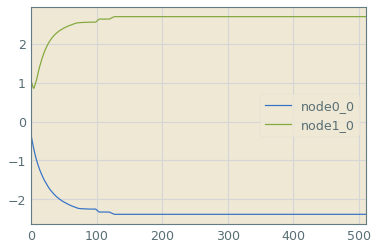

In [84]:
weights_df.filter(regex="node[0-3]_0").plot()

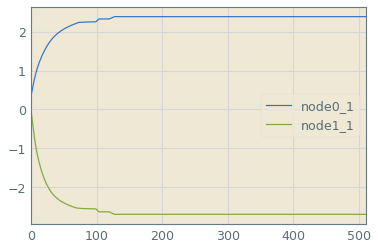

In [85]:
weights_df.filter(regex="node[0-3]_1").plot()

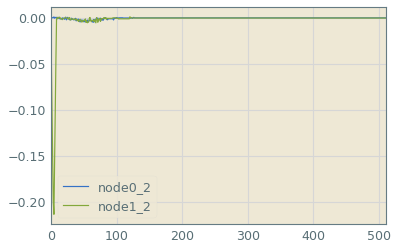

In [86]:
weights_df.filter(regex="node[0-3]_2").plot()

---

## Adding hidden layers

We may add a hidden layer by simply repeating most of the initial part:

In [49]:
model1 = Sequential()

# 1st (Input) layer
model1.add(Dense(input_size, activation='relu', input_shape=(2,)))

Add the 2nd (hidden) layer. This is an internalization of features that are not seen externally to the model:

In [50]:
model1.add(Dense(64, activation='relu'))

And retain the remainder (the output layer):

In [51]:
# 3rd (Output) layer
model1.add(Dense(num_classes, activation='softmax'))

model1.summary()

model1.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history1 = model1.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=128,
                    verbose=0,
                    validation_data=(x_test, y_test))

score1 = model1.evaluate(x_test, y_test, verbose=0)

print('Test loss: {0},      Test accuracy: {1}'.format(score1[0], score1[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 328
Trainable params: 328
Non-trainable params: 0
_________________________________________________________________
Test loss: 1.1920928955078125e-07,      Test accuracy: 1.0


We can see that adding a layer decreased the validation (test) loss dramatically, and improved the accuracy.

Adding layers increases the network _depth_. As the number of hidden layers increase, the network becomes deeper; this is what is referred to as _Deep Learning_.

### Network dropout

Overfitting is an ever-present issue with machine learning models. One means of reducing overfitting is to induce _network dropout_. This involves selecting a subset of the model inputs at random during each training phase. This is simply done in keras, setting the `rate` parameter:

In [ ]:
# keras.layers.Dropout(0.2)  # Induces a 20% drop-out rate

We can add drop-out to the first two layers of our MLP:

In [52]:
model2 = Sequential()
# 1st (Input) layer
model2.add(Dense(input_size, activation='relu', input_shape=(2,)))
model2.add(Dropout(0.1))

# 2nd (Hidden) layer
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.1))

# 3rd (Output) layer
model2.add(Dense(num_classes, activation='softmax'))

model2.summary()

model2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history2 = model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=128,
                    verbose=0,
                    validation_data=(x_test, y_test))

score2 = model2.evaluate(x_test, y_test, verbose=0)

print('Test loss: {0},      Test accuracy: {1}'.format(score2[0], score2[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout (Dropout)            (None, 2)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                192       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 130       
Total params: 328
Trainable params: 328
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.04022257467162269,      Test accuracy: 1.0


### Increasing the width of the model

Note the width on the above models is 16 neurons. This is not many! Let's increase this to 512 for the non-output layers:

In [53]:
# Base model
model3 = Sequential()
# 1st (Input) layer
model3.add(Dense(512, activation='relu', input_shape=(2,)))
model3.add(Dropout(0.2))  # Increased the drop-out rate

# 2nd (Hidden) layer
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.2))

# 3rd (Output) layer
model3.add(Dense(num_classes, activation='softmax'))

print("Model 3 summary: {0}".format(model3.summary()))

model3.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history3 = model3.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))

score3 = model3.evaluate(x_test, y_test, verbose=0)

print('Test loss: {0},      Test accuracy: {1}'.format(score3[0], score3[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               1536      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 1026      
Total params: 265,218
Trainable params: 265,218
Non-trainable params: 0
_________________________________________________________________
Model 3 summary: None
Test loss: 1.1920928955078125e-07,      Test accuracy: 1.0


So increasing the model's depth improved the validation accuracy and reduced the error.

It is interesting to see how the training and validation errors of each of these models improves with each epoch:

![Comparison of the four models as a function of epoch. Note the decrease in error rate with epoch is rapid in the early stages of training.](images/Perceptron_training_comparisons.png)

### Appropriate applications of Artificial Neural Networks

Because ANNs are 'universal approximators,' as well as based on a large number of small, simple, units, they are great where:
 * The relationships between variables are poorly understood or analytically complex
 * There is a lot of data
 
They are not so great because:
 * Principal features are not explicitly apparent; decisions are opaque for deep networks
 * They can be slow to train, requiring a number of epochs 

### Additional resources


**Websites:** 

  * Michael A. Neilsen's _Neural Nets and Deep Learning_: http://neuralnetworksanddeeplearning.com/
  * Ian Goodfellow, Yoshua Bengio and Aaron Courville's _Deep Learning_: http://www.deeplearningbook.org

**YouTube channels:**

 * Andrew Ng's _Machine Learning_: https://www.youtube.com/watch?v=PPLop4L2eGk&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN
 * Sentdex's _Practical Machine Learning with Python_: https://www.youtube.com/watch?v=OGxgnH8y2NM&index=1&list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v

**Platforms:** 

 * Kaggle: https://www.kaggle.com/
 * Coursera (Andrew Ng again): https://www.coursera.org/learn/machine-learning

# Conclusion


This was a very brief introduction to the field of artificial neural networks (ANNs) and Deep Learning!

We have examined the theoretical justification for (ANNs), demonstrating that they are great ‘universal approximators’. We also covered their use-cases and some of their pit-falls.

We also had a brief introduction to TensorFlow and Keras. We built a feed-forward network (a Multi-Layer Perceptron; MLP) to approximate complex functions. We ‘tweaked’ this model, improving the output, and evaluated its performance. In order to determine this, we also covered the concepts of appropriate activation functions, optimizers and cost functions.

Perhaps most importantly: we have figured out how to be satisfied with a simple meal at an altitude of 30,000 feet. People have been trying to achieve this for years!